In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from copy import deepcopy

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [25]:
track=pd.read_csv("nfl-big-data-bowl-2022/tracking2018.csv")
plays=pd.read_csv("nfl-big-data-bowl-2022/plays.csv")

plays=plays[plays["specialTeamsResult"]=="Return"]  #Look only at kick/punt returns

#Identify name of receivers so that we can match both datasets
plays["receiver"]=plays["playDescription"].map(lambda x: re.findall(" ([A-Z])\.([A-Z].*?) ", x)[-1] if len(re.findall(" [A-Z]\.([A-Z].*?) ", x))>=1 else 0)
plays=plays[plays["receiver"]!=0]
plays["receiver"]=plays["receiver"].map(lambda x: x[:-1] if x[-1]=="," else x)

#Match games and plays in both datasets
plays["gamePlayId"]=list(zip(plays["gameId"], plays["playId"]))
track["gamePlayId"]=list(zip(track["gameId"], track["playId"]))
track=track[track["gamePlayId"].isin(plays["gamePlayId"])]
track=track[track["event"]=="kick_received"]
plays=plays[plays["gamePlayId"].isin(track["gamePlayId"])]

#Create the datasets that match
track["name"]=track["displayName"].map(lambda x: (x.split(" ")[0][0],x.split(" ")[-1]))
plays["nameGamePlayId"]=list(zip(plays["receiver"], plays["gamePlayId"]))
track["nameGamePlayId"]=list(zip(track["name"], track["gamePlayId"]))
track_ret=track[track["nameGamePlayId"].isin(plays["nameGamePlayId"])]
track_ret=track_ret[~track_ret.duplicated("nameGamePlayId", False)]  #Remove seven instances of two players with same initial and last name
plays_ret=plays[plays["nameGamePlayId"].isin(track_ret["nameGamePlayId"])]

track=track[track["gamePlayId"].isin(track_ret["gamePlayId"])]  #Only games and plays where we identified the returner

#Sort values so games are in same place
plays_ret=plays_ret.sort_values("gamePlayId")
plays_ret=plays_ret.reset_index()
track_ret=track_ret.sort_values("gamePlayId")
track_ret=track_ret.reset_index()

In [6]:
data=pd.DataFrame()
data[["gamePlayId", "receiver"]]=plays_ret[["gamePlayId", "receiver"]]
data[["receiverx", "receivery", "receivers", "recerivera", "receiverdir"]]=track_ret[["x", "y", "s", "a", "dir"]]

In [11]:
def closests_players(data, top):
    """
    data Dataframe    Contains data on the playid, receiver name and position
    top dictionary    with values team and opp giving number of closest players for each team
    """
    i=-1
    for play in data["gamePlayId"]:
        ind={}
        dist={}
        X={}
        i+=1
        recxy=data[data["gamePlayId"]==play][["receiverx", "receivery"]]
        recteam=track[(track["gamePlayId"]==play)&(track["name"]==data.iloc[i]["receiver"])]["team"]
        recteam=recteam.values[0]

        X["team"]=track[(track["gamePlayId"]==play) &(track["team"]==recteam)][["x", "y", "s", "a", "dir"]]
        dist["team"]=X["team"][["x", "y"]]-recxy.to_numpy()
        dist["team"]=np.sqrt(dist["team"]["x"]**2+dist["team"]["y"]**2)
        ind["team"]=np.argpartition(dist["team"], top["team"]+1)[1:top["team"]+1]
    
        X["opp"]=track[(track["gamePlayId"]==play) &(track["team"]!=recteam)][["x", "y", "s", "a", "dir"]]
        dist["opp"]=X["opp"][["x", "y"]]-recxy
        dist["opp"]=np.sqrt(dist["opp"]["x"]**2+dist["opp"]["y"]**2)
        ind["opp"]=np.argpartition(dist["opp"], top["opp"])[:top["opp"]]

        for team in ["team", "opp"]:
            for j in range(top[team]):
                for stat in ["x", "y", "s", "a", "dir"]:
                    data.loc[i, team+str(j)+stat]=X[team].iloc[ind[team].iloc[j]][stat]
    return data


In [12]:
datas={}
for i in range(6):
    for j in range(6):
        top={"team":i, "opp":j}
        datas[(i,j)]=closests_players(data[["gamePlayId", "receiver", "receiverx", "receivery"]],top)

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [13]:
with open("datas_trackret_playsret.pickle", "wb") as f:
    pickle.dump((datas, track_ret, plays_ret), f)

In [2]:
with open("datas_trackret_playsret.pickle", "rb") as f:
    datas, track_ret, plays_ret=pickle.load(f)

In [3]:
y=plays_ret["kickReturnYardage"]

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmat

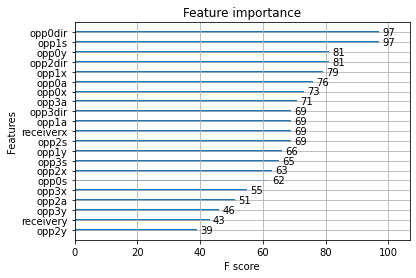

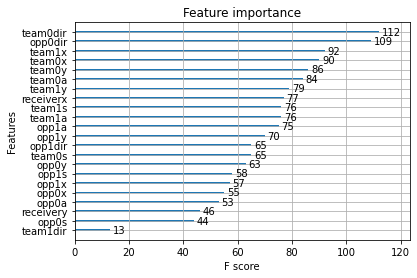

In [4]:
class_scores=pd.DataFrame(columns=["Accuracy", "F1", "ROC"])
for i in range(6):
    for j in range(6):
        scaler=StandardScaler()
        X=scaler.fit_transform(datas[i,j].drop(["gamePlayId", "receiver"],axis=1))
        x_train, x_test, y_train, y_test=train_test_split(X, (y>=20).astype(int), test_size=.2, random_state=1)

        columns=list(datas[i,j].drop(["gamePlayId", "receiver"],axis=1).columns)
        x_train=pd.DataFrame(x_train, columns=columns)
        x_test=pd.DataFrame(x_test, columns=columns)

        xg_reg = xgb.XGBClassifier(use_label_encoder=False, objective ='binary:logistic', eval_metric="logloss", learning_rate = 0.2, num_parallel_tree=1,
                max_depth = 5, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=.1)

        xg_reg.fit(x_train, y_train)

        if (i,j)==(2,2) or (i,j)==(0,4):
            xgb.plot_importance(xg_reg)

        pred=xg_reg.predict(x_test)

        class_scores.loc[str((i,j)),"Accuracy",]=(y_test==pred).sum()/len(y_test)
        class_scores.loc[str((i,j)),"F1"]= f1_score(y_test, pred)
        class_scores.loc[str((i,j)),"ROC"]= roc_auc_score(y_test, pred)

In [5]:
class_scores

,Accuracy,F1,ROC
"(0, 0)",0.716667,0.781116,0.685185
"(0, 1)",0.694444,0.771784,0.652778
"(0, 2)",0.694444,0.77551,0.648148
"(0, 3)",0.722222,0.789916,0.685185
"(0, 4)",0.738889,0.801688,0.703704
"(0, 5)",0.722222,0.793388,0.680556
"(1, 0)",0.705556,0.776371,0.668981
"(1, 1)",0.694444,0.769874,0.655093
"(1, 2)",0.694444,0.771784,0.652778
"(1, 3)",0.722222,0.788136,0.6875


In [6]:
#x invariant, important is difference from returner
class_scores_inv=pd.DataFrame(columns=["Accuracy", "F1", "ROC"])
inv_datas=deepcopy(datas)

for i in range(6):
    for j in range(6):
        xs=[c for c in inv_datas[(i,j)].columns if c[-1]=="x"]
        inv_datas[(i,j)][xs]=(inv_datas[(i,j)][xs].to_numpy().T-inv_datas[(i,j)]["receiverx"].to_numpy()).T
        scaler=StandardScaler()
        X=scaler.fit_transform(inv_datas[i,j].drop(["gamePlayId", "receiver"],axis=1))
        x_train, x_test, y_train, y_test=train_test_split(X, (y>=20).astype(int), test_size=.2, random_state=1)

        xg_reg = xgb.XGBClassifier(use_label_encoder=False, objective ='binary:logistic', eval_metric="logloss", learning_rate = 0.2, num_parallel_tree=1,
                max_depth = 5, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=.1)

        xg_reg.fit(x_train, y_train)

        #xgb.plot_importance(xg_reg)

        pred=xg_reg.predict(x_test)

        class_scores_inv.loc[str((i,j)),"Accuracy",]=(y_test==pred).sum()/len(y_test)
        class_scores_inv.loc[str((i,j)),"F1"]= f1_score(y_test, pred)
        class_scores_inv.loc[str((i,j)),"ROC"]= roc_auc_score(y_test, pred)

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmat

In [7]:
class_scores_inv

,Accuracy,F1,ROC
"(0, 0)",0.622222,0.730159,0.564815
"(0, 1)",0.716667,0.786611,0.678241
"(0, 2)",0.722222,0.791667,0.68287
"(0, 3)",0.733333,0.8,0.694444
"(0, 4)",0.722222,0.786325,0.689815
"(0, 5)",0.761111,0.818565,0.726852
"(1, 0)",0.688889,0.764706,0.650463
"(1, 1)",0.722222,0.793388,0.680556
"(1, 2)",0.7,0.780488,0.652778
"(1, 3)",0.766667,0.823529,0.731481


In [8]:
reg_class_scores=pd.DataFrame(columns=["Error"])
for i in range(6):
    for j in range(6):
        scaler=StandardScaler()
        X=scaler.fit_transform(datas[i,j].drop(["gamePlayId", "receiver"],axis=1))
        y_scaler=StandardScaler()
        y_scale=y_scaler.fit_transform(np.reshape(y.to_numpy(), (-1,1)))
        x_train, x_test, y_train, y_test=train_test_split(X, y_scale, test_size=.2, random_state=1)

        xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, num_parallel_tree=1,
                max_depth = 5, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=.1)

        xg_reg.fit(x_train, y_train)

        #xgb.plot_importance(xg_reg)

        pred=xg_reg.predict(x_test)

        reg_class_scores.loc[str((i,j)),"Error",]=np.sqrt(mean_squared_error(y_test, pred))

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmat

In [9]:
reg_class_scores

,Error
"(0, 0)",0.838301
"(0, 1)",0.856328
"(0, 2)",0.803164
"(0, 3)",0.776515
"(0, 4)",0.753661
"(0, 5)",0.749432
"(1, 0)",0.822756
"(1, 1)",0.833487
"(1, 2)",0.825001
"(1, 3)",0.789443


In [22]:
inv_reg_class_scores=pd.DataFrame(columns=["Error"])
for i in range(6):
    for j in range(6):
        scaler=StandardScaler()
        #X=scaler.fit_transform(datas[i,j].drop(["gamePlayId", "receiver"],axis=1))
        X=datas[i,j].drop(["gamePlayId", "receiver"],axis=1)
        y_scaler=StandardScaler()
        #y_scale=y_scaler.fit_transform(np.reshape(y.to_numpy(), (-1,1)))
        y_scale=y.to_numpy()
        x_train, x_test, y_train, y_test=train_test_split(X, y_scale, test_size=.2, random_state=1)

        xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2, num_parallel_tree=1,
                max_depth = 5, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=.1)

        xg_reg.fit(x_train, y_train)

        #xgb.plot_importance(xg_reg)

        pred=xg_reg.predict(x_test)

        inv_reg_class_scores.loc[str((i,j)),"Error",]=np.sqrt(mean_squared_error(y_test, pred, squared=False))

In [23]:
inv_reg_class_scores

,Error
"(0, 0)",3.17616
"(0, 1)",3.20543
"(0, 2)",3.06779
"(0, 3)",2.99749
"(0, 4)",3.00944
"(0, 5)",2.97873
"(1, 0)",3.19322
"(1, 1)",3.17149
"(1, 2)",3.1137
"(1, 3)",3.05791


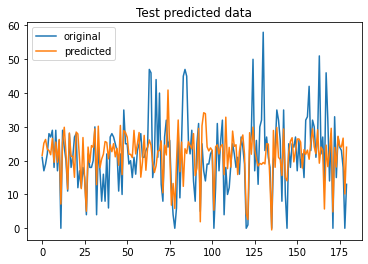

In [24]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, pred, label="predicted")
plt.title("Test predicted data")
plt.legend()
plt.show()

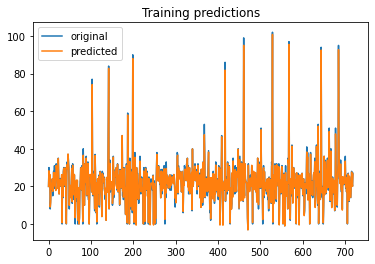

In [21]:
x_ax = range(len(y_train))
plt.plot(x_ax, y_train, label="original")
plt.plot(x_ax, xg_reg.predict(x_train), label="predicted")
plt.title("Training predictions")
plt.legend()
plt.show()

## Upsampling for y>25 as for y>20 is pretty balanced but for 25 is not.

In [14]:
class_scores=pd.DataFrame(columns=["Accuracy", "F1", "ROC"])
for i in range(6):
    for j in range(6):
        scaler=StandardScaler()
        X=scaler.fit_transform(datas[i,j].drop(["gamePlayId", "receiver"],axis=1))
        x_train, x_test, y_train, y_test=train_test_split(X, (y>=25).astype(int), test_size=.2, random_state=1)

        xg_reg = xgb.XGBClassifier(use_label_encoder=False, objective ='binary:logistic', eval_metric="logloss", learning_rate = 0.2, num_parallel_tree=1,
                max_depth = 5, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=.1)

        xg_reg.fit(x_train, y_train)

        #xgb.plot_importance(xg_reg)

        pred=xg_reg.predict(x_test)

        class_scores.loc[str((i,j)),"Accuracy",]=(y_test==pred).sum()/len(y_test)
        class_scores.loc[str((i,j)),"F1"]= f1_score(y_test, pred)
        class_scores.loc[str((i,j)),"ROC"]= roc_auc_score(y_test, pred)

C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\xnive\anaconda3\envs\tf\lib\site-packages\sklearn\utils\extmat

In [15]:
class_scores

,Accuracy,F1,ROC
"(0, 0)",0.6,0.419355,0.557775
"(0, 1)",0.616667,0.410256,0.565805
"(0, 2)",0.611111,0.396552,0.558559
"(0, 3)",0.622222,0.358491,0.5566
"(0, 4)",0.638889,0.368932,0.570114
"(0, 5)",0.677778,0.45283,0.615354
"(1, 0)",0.605556,0.413223,0.559538
"(1, 1)",0.594444,0.376068,0.542303
"(1, 2)",0.605556,0.348624,0.543087
"(1, 3)",0.65,0.422018,0.59009


In [16]:
from sklearn.utils import resample
bal_class_scores=pd.DataFrame(columns=["Accuracy", "F1", "ROC"])
for i in range(6):
    for j in range(6):
        x_train, x_test, y_train, y_test=train_test_split(datas[(i,j)].drop(["gamePlayId", "receiver"],axis=1), (y>=20).astype(int), test_size=.2, random_state=1)

        x_imbalanced=x_train[y_train==1]
        y_imbalanced=y_train[y_train==1]

        x_oversampled, y_oversampled = resample(x_imbalanced,
                                        y_imbalanced,
                                        replace=True,
                                        n_samples=x_train[y_train == 0].shape[0],
                                        random_state=1)

        x_balanced = np.vstack((x_train[y_train == 0], x_oversampled))
        y_balanced = np.hstack((y_train[y_train == 0], y_oversampled))

        xg_reg = xgb.XGBClassifier(use_label_encoder=False, objective ='binary:logistic', eval_metric="logloss", learning_rate = 0.2, num_parallel_tree=1,
                max_depth = 5, reg_lambda = 1, n_estimators = 100, seed=1, colsample_bytree=.1)

        xg_reg.fit(x_balanced, y_balanced)

        #xgb.plot_importance(xg_reg)

        pred=xg_reg.predict(x_test)

        bal_class_scores.loc[str((i,j)),"Accuracy",]=(y_test==pred).sum()/len(y_test)
        bal_class_scores.loc[str((i,j)),"F1"]= f1_score(y_test, pred)
        bal_class_scores.loc[str((i,j)),"ROC"]= roc_auc_score(y_test, pred)

In [17]:
bal_class_scores

,Accuracy,F1,ROC
"(0, 0)",0.677778,0.712871,0.680556
"(0, 1)",0.655556,0.683673,0.664352
"(0, 2)",0.677778,0.718447,0.675926
"(0, 3)",0.644444,0.673469,0.652778
"(0, 4)",0.65,0.686567,0.652778
"(0, 5)",0.655556,0.683673,0.664352
"(1, 0)",0.683333,0.732394,0.673611
"(1, 1)",0.683333,0.721951,0.68287
"(1, 2)",0.688889,0.722772,0.69213
"(1, 3)",0.616667,0.653266,0.62037
